## Statistical Inference

Supplementary document.
In this netebook, we use statistical techniques to look at the quality of our collected data and recommendations.


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
sns.set_style("darkgrid")

#If Need to re-download some files saved earlier//or scrape again. 
import requests # library to handle requests
import lxml.html as lh
import bs4 as bs
import urllib.request

from IPython.display import HTML
import base64

print('Libraries imported.')

Libraries imported.


#### Restore Our Data
* Restore Singapore Food Venue Data Frame
* Restore Segmented Town Cluster Data

In [2]:
# Restore dataframe collection : 
sg_food_csv  = r'https://raw.githubusercontent.com/crismag/Coursera_Capstone/master/saved_data/singapore_food_venues.600Scores.Category.csv'
venue_columns = ['Town','Town Latitude','Town Longitude','VenueID','VenueName','score','category','catID','latitude','longitude']
singapore_food_venues      = pd.read_csv(sg_food_csv, usecols=venue_columns, encoding = "ISO-8859-1")

# Eliminate possible venue duplicates.
singapore_town_venues = singapore_food_venues[venue_columns]
# Drop rows with score == 0
singapore_town_venues = singapore_town_venues[singapore_town_venues.score > 0.0]
# Drop rows with missing elements
singapore_town_venues = singapore_town_venues.dropna(axis='columns')

singapore_town_venues.head()

,Town,Town Latitude,Town Longitude,VenueID,VenueName,score,category,catID,latitude,longitude
2,ANG MO KIO,1.369972,103.849588,50138eaee4b05d9dc80ae5b0,Hong Kong Sheng Kee Dessert ??????,5.8,Dessert Shops,4bf58dd8d48988d1d0941735,1.369473,103.849241
4,ANG MO KIO,1.369972,103.849588,5be2d3831af8520039a38da2,Malaysia Boleh!,7.5,Food Courts,4bf58dd8d48988d120951735,1.369669,103.848900
5,ANG MO KIO,1.369972,103.849588,4b7cdf36f964a520fda72fe3,BreadTalk / Toast Box,5.5,Breakfast Spots,4bf58dd8d48988d143941735,1.369177,103.848874
7,ANG MO KIO,1.369972,103.849588,4b1e9fc6f964a520d21c24e3,Ichiban Sushi,5.6,Sushi Restaurants,4bf58dd8d48988d1d2941735,1.369156,103.849109
10,ANG MO KIO,1.369972,103.849588,5340222411d247b11bb27bb8,Eighteen Chefs,5.5,Diners,4bf58dd8d48988d147941735,1.369265,103.848706


In [3]:
sg_top_clusters = r'https://raw.githubusercontent.com/crismag/Coursera_Capstone/master/saved_data/sg_top_clusters.csv'
sg_town_clusters = pd.read_csv(sg_top_clusters)
#sg_town_clusters.head()

In [4]:
rent_cluster_df = sg_town_clusters[['Town','median_rent','Cluster Labels']].copy()

In [5]:
#Analyze Each Singapore Town nearby recommended venues

# one hot encoding
sg_onehot = pd.get_dummies(singapore_town_venues[['category']], prefix="", prefix_sep="")

# add Town column back to dataframe
sg_onehot['Town'] = singapore_town_venues['Town'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(sg_onehot.shape[0]))

# Regroup rows by town and mean of frequency occurrence per category.
sg_grouped_mean = sg_onehot.groupby('Town').mean().reset_index()
sg_grouped_sum  = sg_onehot.groupby('Town').sum().reset_index()

print('One hot [MEAN] encoding re-group returned "{}" rows.'.format(sg_grouped_mean.shape[0]))
print('One hot [SUM] encoding re-group returned "{}" rows.'.format(sg_grouped_sum.shape[0]))

One hot encoding returned "644" rows.
One hot [MEAN] encoding re-group returned "25" rows.
One hot [SUM] encoding re-group returned "25" rows.


In [6]:
print("sg_grouped_mean")
sg_grouped_mean.head()

sg_grouped_mean


,Town,American Restaurants,Asian Restaurants,BBQ Joints,Bakeries,Bars,Bistros,Breakfast Spots,Breweries,Bubble Tea Shops,...,Snack Places,Soup Places,Steakhouses,Sushi Restaurants,Taiwanese Restaurants,Thai Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wings Joints
0,ANG MO KIO,0.000000,0.000000,0.0,0.029412,0.0,0.000000,0.029412,0.0,0.029412,...,0.029412,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000
1,BEDOK,0.034483,0.034483,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.068966,0.0,0.000000,0.0,0.0,0.0,0.034483
2,BISHAN,0.027778,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.055556,...,0.000000,0.0,0.0,0.000000,0.0,0.027778,0.0,0.0,0.0,0.000000
3,BUKIT BATOK,0.000000,0.045455,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.045455,0.0,0.0,0.0,0.000000
4,BUKIT MERAH,0.000000,0.000000,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [7]:
print("sg_grouped_sum")
sg_grouped_sum.head()

sg_grouped_sum


,Town,American Restaurants,Asian Restaurants,BBQ Joints,Bakeries,Bars,Bistros,Breakfast Spots,Breweries,Bubble Tea Shops,...,Snack Places,Soup Places,Steakhouses,Sushi Restaurants,Taiwanese Restaurants,Thai Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wings Joints
0,ANG MO KIO,0,0,0,1,0,0,1,0,1,...,1,0,0,2,0,0,0,0,0,0
1,BEDOK,1,1,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
2,BISHAN,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,1,0,0,0,0
3,BUKIT BATOK,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,BUKIT MERAH,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Standardize neighborhood rental prices:
scaler = StandardScaler()
standardized_price = scaler.fit_transform(sg_town_clusters[['median_rent']])

# add the normalized price to the dataframe
sg_town_clusters = pd.DataFrame(sg_grouped_sum)
sg_town_clusters['median_rent_std'] = standardized_price

print(sg_town_clusters.shape)
sg_town_clusters

(25, 69)


,Town,American Restaurants,Asian Restaurants,BBQ Joints,Bakeries,Bars,Bistros,Breakfast Spots,Breweries,Bubble Tea Shops,...,Soup Places,Steakhouses,Sushi Restaurants,Taiwanese Restaurants,Thai Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wings Joints,median_rent_std
0,ANG MO KIO,0,0,0,1,0,0,1,0,1,...,0,0,2,0,0,0,0,0,0,-0.117356
1,BEDOK,1,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,0.196301
2,BISHAN,1,0,0,0,0,0,0,0,2,...,0,0,0,0,1,0,0,0,0,1.040763
3,BUKIT BATOK,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-0.527523
4,BUKIT MERAH,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.630596
5,BUKIT PANJANG,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,-1.830407
6,CENTRAL,1,1,0,0,0,1,0,1,1,...,0,0,0,0,1,1,0,0,0,2.295392
7,CHOA CHU KANG,0,2,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,-0.696416
8,CLEMENTI,1,2,0,0,0,0,0,0,0,...,1,1,0,0,2,0,0,0,0,1.214481
9,GEYLANG,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0.654723


## DATA FRAME ANALYSIS

#### Check if theres a relationship between median rental prices and the quality of venue recommendations in the area.

### TEST1. LinearRegression

In [9]:
# LinearRegression - check correlations - the median rent and recommendations count.
lreg = LinearRegression(normalize=True)

X = sg_town_clusters.drop(columns=['Town', 'median_rent_std'])
y = sg_town_clusters['median_rent_std']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)


In [10]:
# LR FIT
y_pred = lreg.predict(X_test)

r2s = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
lreg_coeff_pos = lreg.coef_[np.argsort(-lreg.coef_)[:10]]
lreg_coeff_neg = lreg.coef_[np.argsort(lreg.coef_)[:10]]
lreg_coeff_abs = abs(lreg.coef_)
lreg_coeff_max = "";#lreg.coef_[np.argsort(lreg_coeff_abs)[:10]]
lreg_coeff_min = lreg.coef_[np.argsort(lreg_coeff_abs)[:10]]

print('R2-score           :', r2s )
print('MEAN Squared Error :', mse )
print('ABS coefs          :', lreg_coeff_abs)
print('Coefficients:')
print('\tPOSITIVE = ',lreg_coeff_pos)
print('\tNEGATIVE = ',lreg_coeff_neg)
print('Venue types nearly correlated      :', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Venue types inversely correlated   :', X.columns[np.argsort(lreg.coef_)[:10]].values)
print('Venue types not correlated         :', X.columns[np.argsort(lreg_coeff_abs)[:10]].values)

R2-score           : -0.0106616298481
MEAN Squared Error : 1.23165842943
ABS coefs          : [  2.28398100e-01   2.01078675e-01   1.42682682e-01   1.97894138e-01
   7.61245666e-01   1.43316513e-01   7.01449836e-02   2.21944470e-01
   2.61890972e-01   2.21944470e-01   3.57191183e-01   2.22044605e-16
   1.03510406e-01   2.21944470e-01   2.21944470e-01   0.00000000e+00
   8.71719474e-02   1.00764830e-02   2.77555756e-17   2.13323822e-02
   8.50319432e-02   5.55183244e-02   2.21944470e-01   3.51828252e-01
   0.00000000e+00   3.83842613e-02   2.61480467e-01   1.02580757e-01
   0.00000000e+00   1.57289085e-01   4.86281979e-02   2.21944470e-01
   1.17667107e+00   5.44064873e-01   2.50124386e-01   1.86573214e-01
   2.95448960e-01   1.01612781e-01   4.46994253e-02   2.35044200e-01
   1.41113976e-01   1.14502829e-01   1.50288764e-01   0.00000000e+00
   2.10144149e-01   7.86976088e-02   2.21944470e-01   7.01449836e-02
   7.01449836e-02   8.04958574e-02   1.97954014e-01   3.28253294e-01
   7.5997

### TEST2. Principal Component Regression (PCR)

In [12]:
X = sg_town_clusters.drop(columns=['Town', 'median_rent_std'])
y = sg_town_clusters['median_rent_std']

pca   = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

In [13]:
n_component_list = range(1, 25)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

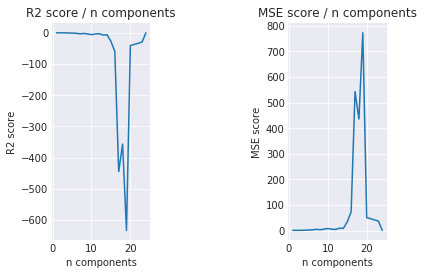

In [14]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [15]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 24 R2 score: 0.113936464977
Best n: 24 MSE: 1.07981503373


In [16]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.113936464977
MSE: 1.07981503373


#### Project the coefs back to the original number of features

In [17]:
corelate_mtx = np.corrcoef(X_train.T)

eig_vals, eig_vecs = np.linalg.eig(corelate_mtx)

#print('Eigenvectors \n%s' %eig_vecs)
#print('\nEigenvalues \n%s' %eig_vals)
print('eig_vecs.shape',eig_vecs.shape)
print('eig_vals.shape',eig_vals.shape)

eig_vecs.shape (24, 24)
eig_vals.shape (24,)


In [18]:
# Let's check which venue types effect the most and least


eig_val_max_pos = eig_vals[np.argsort(-eig_vals)[:10]]
eig_val_max_neg = eig_vals[np.argsort(eig_vals)[:10]]
coef_abs = abs(eig_vals)
print('Coefficients:')
print('\tPOSITIVE = ',eig_val_max_pos)
print('\tNEGATIVE = ',eig_val_max_neg)
print('Venue types nearly correlated      :', X.columns[np.argsort(-eig_vals)[:10]].values)
print('Venue types inversely correlated   :', X.columns[np.argsort(eig_vals)[:10]].values)
print('Venue types not correlated         :', X.columns[np.argsort(coef_abs)[:10]].values)
print('Min coefs                          :', eig_vals[np.argsort(coef_abs)[:10]])

Coefficients:
	POSITIVE =  [ 1.96093109+0.j  1.76568642+0.j  1.54265759+0.j  1.51104148+0.j
  1.35646371+0.j  1.32401116+0.j  1.29234793+0.j  1.21672339+0.j
  1.19957332+0.j  1.15716130+0.j]
	NEGATIVE =  [ -3.70658000e-17 +0.00000000e+00j  -1.82301253e-17 +0.00000000e+00j
   2.29798003e-16 -1.06091443e-16j   2.29798003e-16 +1.06091443e-16j
   3.25231420e-16 +0.00000000e+00j   1.00932766e+00 +0.00000000e+00j
   1.03599833e+00 +0.00000000e+00j   1.04319136e+00 +0.00000000e+00j
   1.04984710e+00 +0.00000000e+00j   1.06762085e+00 +0.00000000e+00j]
Venue types nearly correlated      : ['American Restaurants' 'Asian Restaurants' 'BBQ Joints' 'Bakeries' 'Bars'
 'Bistros' 'Breakfast Spots' 'Breweries' 'Bubble Tea Shops' 'Burger Joints']
Venue types inversely correlated   : ['Dongbei Restaurants' 'Dumpling Restaurants' 'Diners'
 'Dim Sum Restaurants' 'Dessert Shops' 'Buffets' 'Cantonese Restaurants'
 'Chinese Breakfast Places' 'Cha Chaan Tengs' 'Chinese Restaurants']
Venue types not correlated 

## Inferential Statistics Conclusion

The results seems to be consistent with common expectations such that High class restaurants exists in more expensive places to live in the city. Certain types of dining areas like 'Restaurants' tends to appear more on more costly places. Common dining places that are available all across Singapore does not correlate correlate well in this analysis. This can also be a correct result when not considering the score ratings of these dining places.
